# Word Level Federated Text Generation with Stack Overflow with and without Pretrained Word Embeddings
- Joel Stremmel
- 02-10-20
- GCP 

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer in the LSTM is optionally initialized with either GloVe or FastText Embeddings.

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !sudo pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip uninstall tensorflow
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [5]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Test TFF

In [8]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model
**Note:** Ask Keith how he's been setting there for internal experiments.

In [9]:
VOCAB_SIZE = 10000
BATCH_SIZE = 8
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 20
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 100
EMBEDDING_PATH = ''
# EMBEDDING_PATH = '../word_embeddings/glove/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
# EMBEDDING_PATH = '../word_embeddings/fasttext/wiki-news-{}d-1M.vec'.format(EMBEDDING_DIM)

RNN_UNITS = 100

### Load and Preprocess Word Level Datasets

In [10]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [11]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [12]:
pad, oov, bos, eos = dataset.get_special_tokens(vocab_size=VOCAB_SIZE)

In [13]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [14]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [15]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [16]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Load Pretrained Word Embeddings
- Either [GloVe embeddings from Stanford](https://nlp.stanford.edu/projects/glove/) - license [here](https://www.opendatacommons.org/licenses/pddl/1.0/)
- Or [FastText embeddings from Facebook](https://fasttext.cc/docs/en/english-vectors.html) - license [here](https://creativecommons.org/licenses/by-sa/3.0/)

### Create Embedding Matrix from Words in Word Index and Word Embeddings
If `EMBEDDING_PATH` is an empy string, the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.

In [17]:
if EMBEDDING_PATH:
    embedding_matrix=embeddings.create_matrix_from_pretrained_embeddings(
        embedding_path=EMBEDDING_PATH,
        embedding_dim=EMBEDDING_DIM,
        word2idx=word2idx)
else:
    embedding_matrix = 'uniform'

### Load or Build the Model and Try Generating Some Text

In [18]:
keras_model = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS)

generate_text.generate_text(model=keras_model,
                            word2idx=word2idx,
                            idx2word=idx2word,
                            start_string='How are you today')

'how are you today archived bizarre fee bothers doubts multiples treemap however color dojo flavors subset synonym claiming yarn adhere scripting aid dumped tie volume centos textual vertical-align lat 360 transferred substring attachments multi v0 bits liking utilities brackets practices imageviews mailing often copying dozen ad rtf reconsider whenever myfunc img bug sensitive nav'

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [19]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [20]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Set the Default Executor

In [21]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [22]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                        embedding_dim=EMBEDDING_DIM,
                        embedding_matrix=embedding_matrix,
                        rnn_units=RNN_UNITS,
                        vocab_size=VOCAB_SIZE,
                        sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [23]:
server_state = iterative_process.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

Evaluating before training round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 17s 175ms/step - loss: 6.6163 - num_tokens: 136858.0000 - num_tokens_no_oov: 132382.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 8.7682e-05 - accuracy_no_oov: 9.0647e-05 - accuracy_no_oov_no_eos: 9.5759e-05
Sampling 10 new clients.
Round: 0
   Loss: 5.98864555
   num_batches: 644
   num_examples: 5110
   num_tokens: 77475
   num_tokens_no_oov: 74853
   accuracy: 0.03281
   accuracy_no_oov: 0.02999
Evaluating before training round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 183ms/step - loss: 6.3964 - num_tokens: 131785.0000 - num_tokens_no_oov: 127802.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0065 - accuracy_no_oov: 0.0066 - accuracy_no_oov_no_eos: 0.0070
Sampling 10 new clients.
Round: 1
   Loss: 8.33202744
   num_batches: 217
   num_examples: 1707
   num_tokens: 23365
   num_tokens_no_oov: 22594
   accuracy: 0.00158
   accuracy_no_oov: 0.00164
Evaluating before training round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 192ms/step - loss: 6.5621 - num_tokens: 135712.0000 - num_tokens_no_oov: 131272.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0117 - accuracy_no_oov: 0.0120 - accuracy_no_oov_no_eos: 0.0127
Sampling 10 new clients.
Round: 2
   Loss: 6.43758392
   num_batches: 398
   num_examples: 3141
   num_tokens: 37009
   num_tokens_no_oov: 35867
   accuracy: 0.00038
   accuracy_no_oov: 0.00039
Evaluating before training round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 180ms/step - loss: 6.5494 - num_tokens: 135564.0000 - num_tokens_no_oov: 130963.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0049 - accuracy_no_oov: 0.0051 - accuracy_no_oov_no_eos: 0.0054
Sampling 10 new clients.
Round: 3
   Loss: 6.62145710
   num_batches: 350
   num_examples: 2759
   num_tokens: 37004
   num_tokens_no_oov: 36109
   accuracy: 0.00022
   accuracy_no_oov: 0.00022
Evaluating before training round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 185ms/step - loss: 6.3291 - num_tokens: 130378.0000 - num_tokens_no_oov: 126545.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0014 - accuracy_no_oov: 0.0014 - accuracy_no_oov_no_eos: 0.0015
Sampling 10 new clients.
Round: 4
   Loss: 6.85268593
   num_batches: 338
   num_examples: 2672
   num_tokens: 38388
   num_tokens_no_oov: 37294
   accuracy: 0.00003
   accuracy_no_oov: 0.00003
Evaluating before training round #5 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 191ms/step - loss: 6.5850 - num_tokens: 136597.0000 - num_tokens_no_oov: 131635.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 3.6604e-05 - accuracy_no_oov: 3.7984e-05 - accuracy_no_oov_no_eos: 4.0104e-05
Sampling 10 new clients.
Round: 5
   Loss: 5.82584524
   num_batches: 606
   num_examples: 4814
   num_tokens: 65640
   num_tokens_no_oov: 63835
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #6 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 180ms/step - loss: 6.5488 - num_tokens: 135743.0000 - num_tokens_no_oov: 132039.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 6
   Loss: 6.46575499
   num_batches: 396
   num_examples: 3134
   num_tokens: 42333
   num_tokens_no_oov: 40879
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #7 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 194ms/step - loss: 6.1705 - num_tokens: 127229.0000 - num_tokens_no_oov: 123564.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 7
   Loss: 5.70434046
   num_batches: 386
   num_examples: 3044
   num_tokens: 38768
   num_tokens_no_oov: 37824
   accuracy: 0.00003
   accuracy_no_oov: 0.00003
Evaluating before training round #8 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 176ms/step - loss: 6.6389 - num_tokens: 138760.0000 - num_tokens_no_oov: 134032.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 8
   Loss: 5.66007853
   num_batches: 367
   num_examples: 2911
   num_tokens: 33782
   num_tokens_no_oov: 32606
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #9 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 187ms/step - loss: 6.2554 - num_tokens: 130356.0000 - num_tokens_no_oov: 126049.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 9
   Loss: 4.63875866
   num_batches: 724
   num_examples: 5752
   num_tokens: 68119
   num_tokens_no_oov: 65843
   accuracy: 0.02571
   accuracy_no_oov: 0.02659
Evaluating before training round #10 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 179ms/step - loss: 6.2576 - num_tokens: 131320.0000 - num_tokens_no_oov: 127078.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 10
   Loss: 6.58461380
   num_batches: 251
   num_examples: 1970
   num_tokens: 26899
   num_tokens_no_oov: 26110
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #11 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 185ms/step - loss: 6.1273 - num_tokens: 129572.0000 - num_tokens_no_oov: 126027.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+0083 - num_tokens: 77810.0000 - num_tokens_no_oov: 75691.0000 - num_batches: 60.0000 - num_examples: 6000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.00
Sampling 10 new clients.
Round: 11
   Loss: 4.60773897
   num_batches: 1284
   num_examples: 10236
   num_tokens: 136310
   num_tokens_no_oov: 132919
   accuracy: 0.02321
   accuracy_no_oov: 0.02168
Evaluating before training round #12 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 178ms/step - loss: 6.6034 - num_tokens: 143324.0000 - num_tokens_no_oov: 137402.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 12
   Loss: 6.24757051
   num_batches: 243
   num_examples: 1911
   num_tokens: 25165
   num_tokens_no_oov: 24406
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #13 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 179ms/step - loss: 6.0398 - num_tokens: 131138.0000 - num_tokens_no_oov: 126725.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 13
   Loss: 6.12255526
   num_batches: 248
   num_examples: 1956
   num_tokens: 25444
   num_tokens_no_oov: 24618
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #14 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 183ms/step - loss: 6.2286 - num_tokens: 137915.0000 - num_tokens_no_oov: 133821.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 14
   Loss: 6.23470211
   num_batches: 219
   num_examples: 1711
   num_tokens: 21708
   num_tokens_no_oov: 21175
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #15 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 182ms/step - loss: 6.2209 - num_tokens: 140127.0000 - num_tokens_no_oov: 133619.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 15
   Loss: 4.39279652
   num_batches: 964
   num_examples: 7660
   num_tokens: 102327
   num_tokens_no_oov: 96860
   accuracy: 0.04249
   accuracy_no_oov: 0.02737
Evaluating before training round #16 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 205ms/step - loss: 5.7728 - num_tokens: 130922.0000 - num_tokens_no_oov: 126886.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 16
   Loss: 5.64487314
   num_batches: 279
   num_examples: 2196
   num_tokens: 28353
   num_tokens_no_oov: 27664
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #17 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 185ms/step - loss: 5.9924 - num_tokens: 139096.0000 - num_tokens_no_oov: 135218.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 17
   Loss: 5.38675356
   num_batches: 442
   num_examples: 3498
   num_tokens: 49663
   num_tokens_no_oov: 48546
   accuracy: 0.00415
   accuracy_no_oov: 0.00424
Evaluating before training round #18 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 195ms/step - loss: 5.8443 - num_tokens: 137534.0000 - num_tokens_no_oov: 133315.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 18
   Loss: 4.64369392
   num_batches: 705
   num_examples: 5603
   num_tokens: 73412
   num_tokens_no_oov: 71165
   accuracy: 0.00602
   accuracy_no_oov: 0.00621
Evaluating before training round #19 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 180ms/step - loss: 5.5494 - num_tokens: 132338.0000 - num_tokens_no_oov: 128201.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 19
   Loss: 4.53863144
   num_batches: 1150
   num_examples: 9162
   num_tokens: 128501
   num_tokens_no_oov: 125457
   accuracy: 0.03328
   accuracy_no_oov: 0.03388


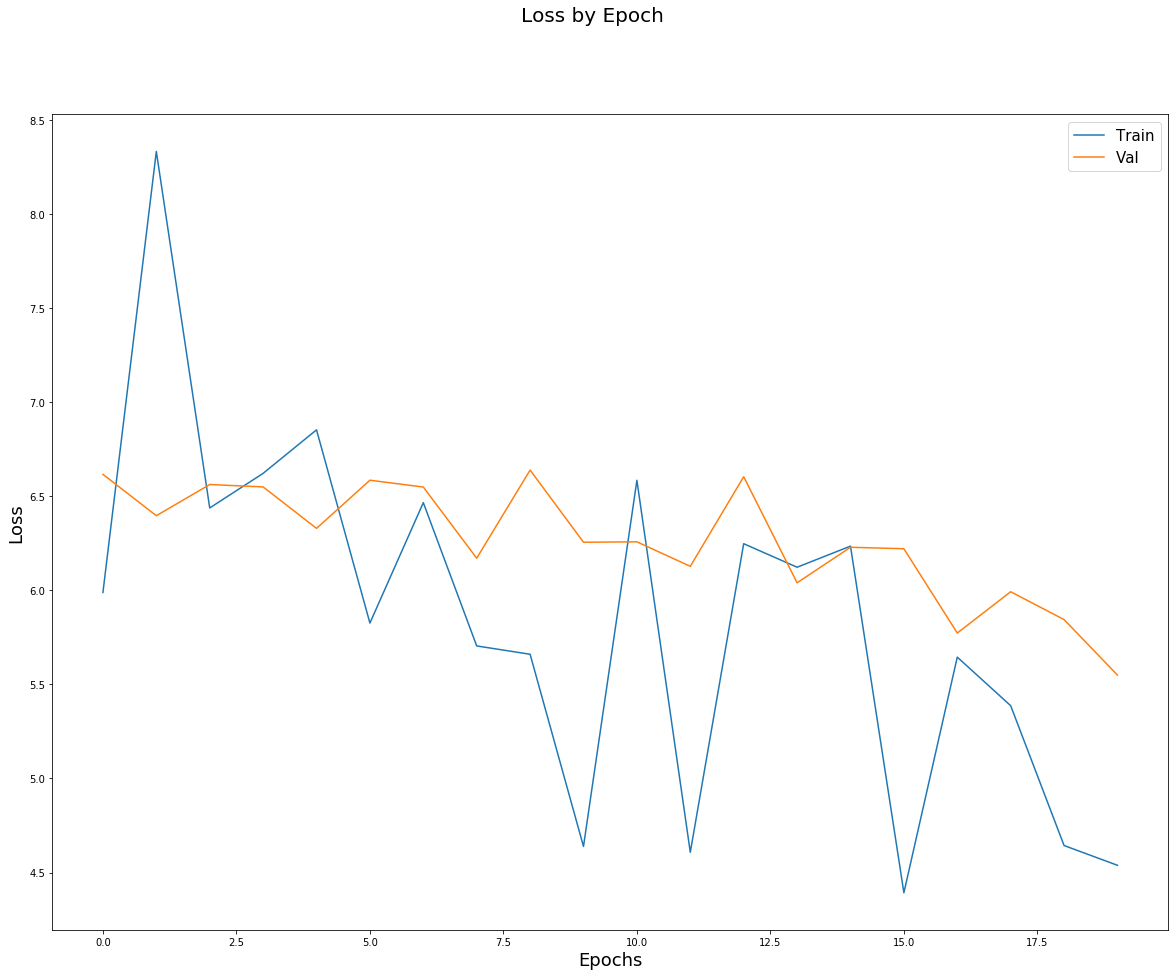

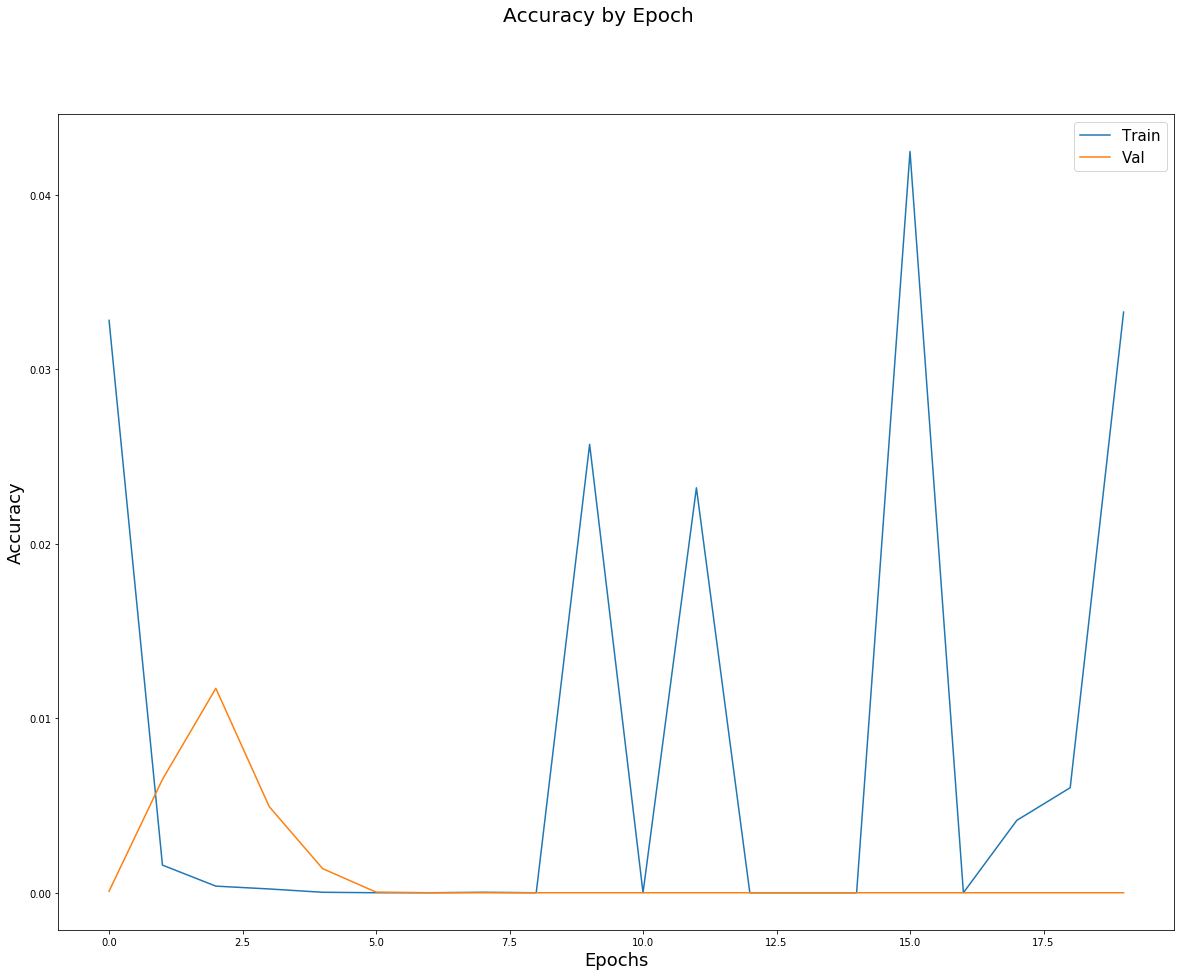

In [24]:
try:
    for round_num in range(0, NUM_ROUNDS):

        # Examine validation metrics
        print('Evaluating before training round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
        validation.keras_evaluate(state=server_state,
                                  val_dataset=val_data,
                                  extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                  vocab_size=VOCAB_SIZE,
                                  embedding_dim=EMBEDDING_DIM,
                                  embedding_matrix=embedding_matrix,
                                  rnn_units=RNN_UNITS,
                                  metrics_tracker=val_metrics_tracker)

        # Sample train clients to create a train dataset
        print('Sampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
        train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        train_metrics_tracker.add_metrics_by_name('num_examples', server_metrics.num_examples)
        train_metrics_tracker.add_metrics_by_name('num_tokens', server_metrics.num_tokens)
        train_metrics_tracker.add_metrics_by_name('num_tokens_no_oov', server_metrics.num_tokens_no_oov)
        
        # Save loss and accuracy from train and validation sets
        np.save('train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save('val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
        np.save('train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save('val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
        # Save train sample stats
        np.save('num_examples.npy', train_metrics_tracker.get_metrics_by_name('num_examples'))
        np.save('num_tokens.npy', train_metrics_tracker.get_metrics_by_name('num_tokens'))
        np.save('num_tokens_no_oov.npy', train_metrics_tracker.get_metrics_by_name('num_tokens_no_oov'))
        
except KeyboardInterrupt as ke:
    
    print('Interrupted')
    
except:
    
    import traceback
    traceback.print_exc()
    
finally:
    
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Loss by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Accuracy by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.show()

### Load Train Sample Stats

In [25]:
examples = np.load('num_examples.npy')
tokens = np.load('num_tokens.npy')
tokens_no_oov = np.load('num_tokens_no_oov.npy')

### Plot Train Sample Stats

In [26]:
round_config = 'Clients: {}, Max Elements per Client: {}, Max Seq Len: {}, Num Rounds: {}'.format(
    NUM_TRAIN_CLIENTS, MAX_ELEMENTS_PER_USER, MAX_SEQ_LENGTH, NUM_ROUNDS)

In [27]:
train_sample_stats = ['Examples', 'Tokens', 'Tokens No OOV']
means = [np.mean(examples), np.mean(tokens), np.mean(tokens_no_oov)]
stdvs = [np.std(examples), np.std(tokens), np.std(tokens_no_oov)]

<Figure size 432x288 with 0 Axes>

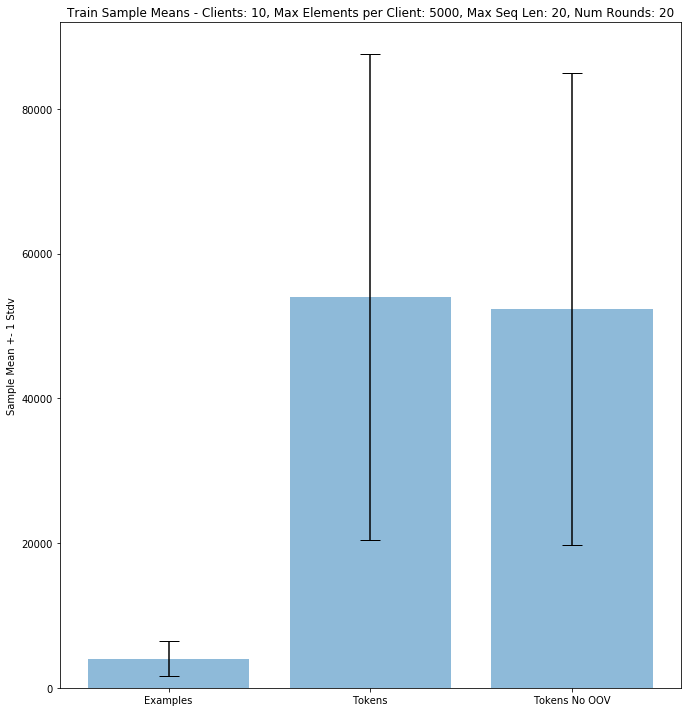

In [28]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
x_pos = np.arange(len(train_sample_stats))
ax.bar(x_pos, means, yerr=stdvs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Sample Mean +- 1 Stdv')
ax.set_xticks(x_pos)
ax.set_xticklabels(train_sample_stats)
ax.set_title('Train Sample Means - {}'.format(round_config))
plt.tight_layout()
plt.savefig('500 Round Train Sample Means.png')
plt.show()

<Figure size 432x288 with 0 Axes>

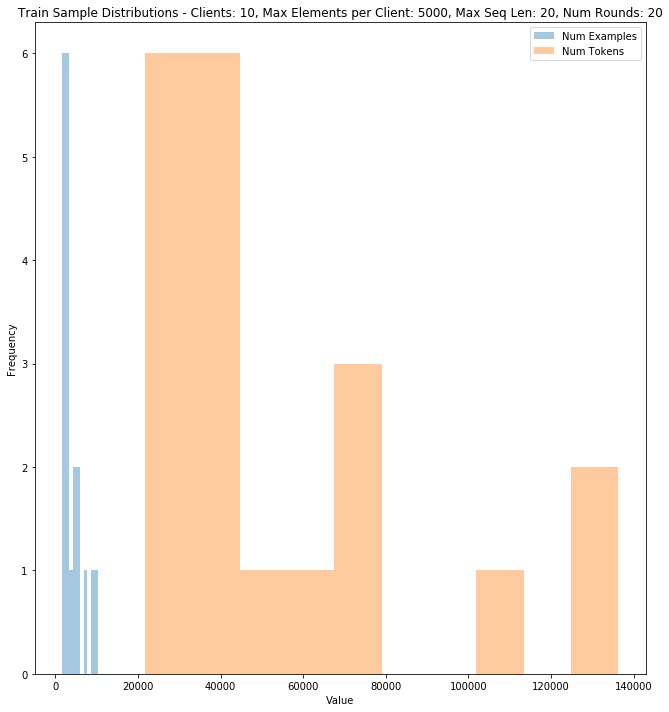

In [29]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.4, label='Num Examples')
plt.hist(tokens, alpha=0.4, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distributions - {}'.format(round_config))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('500 Round Train Sample Distributions.png')
plt.show()

<Figure size 432x288 with 0 Axes>

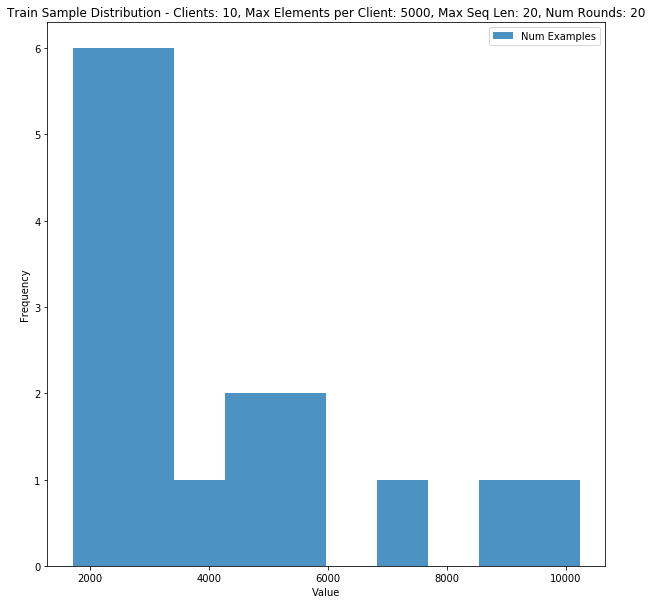

In [30]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.8, label='Num Examples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

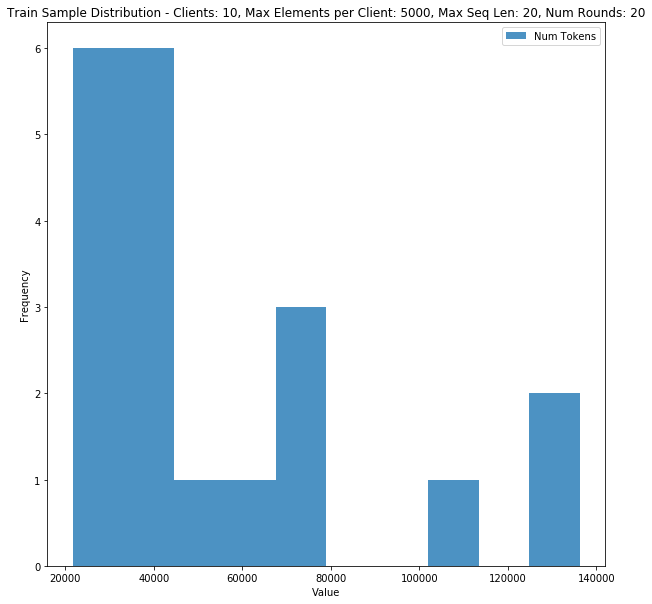

In [31]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens, alpha=0.8, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

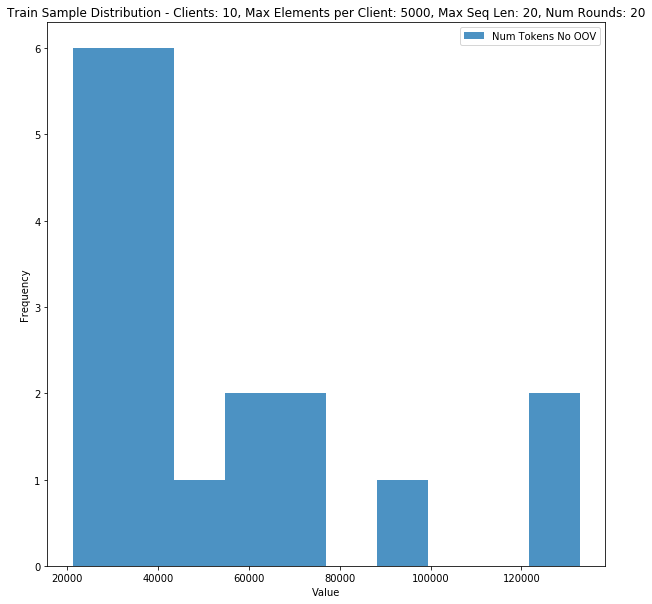

In [32]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens_no_oov, alpha=0.8, label='Num Tokens No OOV')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

### Load Loss and Accuracy Arrays

In [33]:
train_loss = np.load('train_loss.npy')
train_accuracy = np.load('train_accuracy.npy')
val_loss = np.load('val_loss.npy')
val_accuracy = np.load('val_accuracy.npy')

### Validate Array Sizes

In [34]:
train_loss.shape

(20,)

In [35]:
train_accuracy.shape

(20,)

In [36]:
val_loss.shape

(20,)

In [37]:
val_accuracy.shape

(20,)